# IO 2, Problem Set 3

#### Abram and Higbee

In [2]:
# Set wd
pwd()
dir = "/Users/JoshuaHigbee/Box/2. Second Year/2. Winter Quarter - 2021/" * 
        "Industrial Organization II - Hortacsu/Problem Sets/Problem Set 3/";
cd(dir);

# Set up packages (must have pre-loaded)
using Pkg
using CSV, DataFrames, Random, Distributions, LinearAlgebra,
      LatexPrint, StatsBase, Plots, SpecialFunctions
using Optim, ForwardDiff, PyCall, ShiftedArrays, StatsPlots, DataFramesMeta

# Set seed
Random.seed!(12345);

# Set column and row views
#ENV["COLUMNS"]=10000; ENV["ROWS"]=10000;
Base.displaysize() = (100, 100000);

<br><br><br><br>

# 1. Data

In [97]:
dt = CSV.read("ps3clean.csv", DataFrame);
println(size(dt))

(2636, 21)


In [98]:
rename!(dt, [:data_num, :bidder, :house, :date, :lot, :profit, :net_pay, :rank, :p_final, :bid,
                :est_min_d, :est_max_d, :catalog_p, :catalog_d, :est_min, :est_max, :grade_min,
                :grade_max, :no_grade, :excl_us, :no_value]);

In [99]:
dt.auction_num = groupindices(groupby(dt, [:house, :date, :lot]));

In [100]:
dt[!, :num_bidders] .= 0
for i in unique(dt.auction_num)
    dt[dt.auction_num .== i, :num_bidders] .= nrow(dt[dt.auction_num .== i, :])
end;

In [101]:
dt.lot_value = dt.catalog_d .* dt.catalog_p .+ (1 .- dt.catalog_d) .* 0.5 .* (dt.est_min .+ dt.est_max);

In [102]:
first(dt, 10)

,data_num,bidder,house,date,lot,profit,net_pay,rank,p_final,bid,est_min_d,est_max_d,catalog_p,catalog_d,est_min,est_max,grade_min,grade_max,no_grade,excl_us,no_value,auction_num,num_bidders,lot_value
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Int64?,Int64,Int64,Int64,Int64,Int64?,Int64,Float64
1,1,1,A,35360,217,150.0,-150.0,1,5200,8000,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
2,2,2,A,35360,217,150.0,150.0,2,5200,5500,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
3,3,1,A,35360,218,0.0,0.0,1,1000,950,300,400,0.0,0,300.0,400.0,5,2,0,1,0,2,1,350.0
4,4,1,A,35360,220,0.0,0.0,1,1500,1500,1000,1200,0.0,0,1000.0,1200.0,5,2,0,1,0,3,1,1100.0
5,5,1,A,35360,222,0.0,0.0,1,4800,4750,4000,5000,0.0,0,4000.0,5000.0,3,2,0,1,0,4,1,4500.0
6,6,1,A,35360,350,0.0,0.0,1,2200,2100,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
7,7,2,A,35360,350,0.0,0.0,2,2200,1700,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
8,8,3,A,35360,350,0.0,0.0,3,2200,1050,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
9,9,1,A,35360,351,0.0,0.0,1,1400,550,1000,1200,0.0,0,1000.0,1200.0,2,2,0,0,0,6,1,1100.0


<br><br>

### Table 1

In [115]:
houses = unique(dt.house)
tab_1 = DataFrame(house = houses, tgt_mean = fill(0,6), tgt_sd = fill(0,6), knock_mean = fill(0,6), 
    knock_sd = fill(0,6), perc_lots_won = fill(0,6), perc_val_won = fill(0,6), num_lots = fill(0,6), 
    num_sales = fill(0,6))

for house in houses

    # Get data
    dt_h = dt[dt.house .== house, :]
    dt_h1 = dt_h[dt_h.rank .== 1, :]
    
    # Target auction values
    tab_1[tab_1.house .== house, :tgt_mean] .= Int(round(mean(dt_h.p_final), digits=0))
    tab_1[tab_1.house .== house, :tgt_sd] .= Int(round(std(dt_h.p_final), digits=0))
    
    # Knockout auction values
    tab_1[tab_1.house .== house , :knock_mean] .= 
        Int(round(mean(dt_h[dt_h.rank .== 1, :bid]), digits=0))
    tab_1[tab_1.house .== house, :knock_sd] .= 
        Int(round(std(dt_h[dt_h.rank .== 1, :bid]), digits=0))
    
    # Perc of lots/value won by ring
    tab_1[tab_1.house .== house , :perc_lots_won] .= 
        Int(round.(mean(100*(dt_h1.bid .≥ dt_h1.p_final)), digits=0))
    tab_1[tab_1.house .== house , :perc_val_won] .= 
        Int(round.(100*sum(dt_h1[dt_h1.bid .≥ dt_h1.p_final, :lot_value])/sum(dt_h1.lot_value), digits=0))
    
    # Number of lots and sales
    tab_1[tab_1.house .== house , :num_lots] .= nrow(dt_h1)
    tab_1[tab_1.house .== house , :num_sales] .= length(unique(dt_h1.date))
end;

In [116]:
tab_1

,house,tgt_mean,tgt_sd,knock_mean,knock_sd,perc_lots_won,perc_val_won,num_lots,num_sales
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,A,1531,1572,1534,1988,28,48,29,1
2,B,1174,1606,1686,4009,65,43,37,1
3,C,1388,1933,1257,2739,63,66,413,2
4,D,1424,1584,1219,1924,46,52,153,1
5,E,3141,2918,5562,6812,87,95,127,1
6,F1,2036,3057,2023,4195,48,61,100,2


<br><br>

### Table 2

In [126]:
bid_nums = sort(unique(dt.num_bidders))
tab_2 = DataFrame(num_bids = bid_nums, tgt_mean = fill(0,8), tgt_sd = fill(0,8), knock_mean = fill(0,8), 
    knock_sd = fill(0,8), perc_lots_won = fill(0,8), num_lots = fill(0,8))

for bid in bid_nums

    # Get data
    dt_b = dt[dt.num_bidders .== bid, :]
    dt_b1 = dt_b[dt_b.rank .== 1, :]
    
    # Target auction values
    tab_2[tab_2.num_bids .== bid, :tgt_mean] .= Int(round(mean(dt_b.p_final), digits=0))
    tab_2[tab_2.num_bids .== bid, :tgt_sd] .= Int(round(std(dt_b.p_final), digits=0))
    
    # Knockout auction values
    tab_2[tab_2.num_bids .== bid, :knock_mean] .= 
        Int(round(mean(dt_b[dt_b.rank .== 1, :bid]), digits=0))
    tab_2[tab_2.num_bids .== bid, :knock_sd] .= 
        Int(round(std(dt_b[dt_b.rank .== 1, :bid]), digits=0))
    
    # Perc of lots/value won by ring
    tab_2[tab_2.num_bids .== bid, :perc_lots_won] .= 
        Int(round.(mean(100*(dt_b1.bid .≥ dt_b1.p_final)), digits=0))
    
    # Number of lots and sales
    tab_2[tab_2.num_bids .== bid, :num_lots] .= nrow(dt_b1)
end;

In [127]:
tab_2

,num_bids,tgt_mean,tgt_sd,knock_mean,knock_sd,perc_lots_won,num_lots
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,567,862,497,899,28,267
2,2,991,1800,1183,3612,59,149
3,3,1221,1508,1437,1969,68,127
4,4,2030,2815,3062,5857,77,110
5,5,1755,2319,2921,4938,84,79
6,6,2327,3121,3952,5600,89,55
7,7,2722,2036,5305,4326,96,51
8,8,4290,2501,8293,4676,95,21


#### Remove auctions with more than 2 ring bidders

In [129]:
dt = dt[dt.num_bidders .≤ 2, :];

In [141]:
size(dt)

(565, 24)

<br><br><br><br>

# 2. Introductory Questions

### Table 5

In [132]:
first(dt, 10)

,data_num,bidder,house,date,lot,profit,net_pay,rank,p_final,bid,est_min_d,est_max_d,catalog_p,catalog_d,est_min,est_max,grade_min,grade_max,no_grade,excl_us,no_value,auction_num,num_bidders,lot_value
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Int64?,Int64,Int64,Int64,Int64,Int64?,Int64,Float64
1,1,1,A,35360,217,150.0,-150.0,1,5200,8000,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
2,2,2,A,35360,217,150.0,150.0,2,5200,5500,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
3,3,1,A,35360,218,0.0,0.0,1,1000,950,300,400,0.0,0,300.0,400.0,5,2,0,1,0,2,1,350.0
4,4,1,A,35360,220,0.0,0.0,1,1500,1500,1000,1200,0.0,0,1000.0,1200.0,5,2,0,1,0,3,1,1100.0
5,5,1,A,35360,222,0.0,0.0,1,4800,4750,4000,5000,0.0,0,4000.0,5000.0,3,2,0,1,0,4,1,4500.0
6,9,1,A,35360,351,0.0,0.0,1,1400,550,1000,1200,0.0,0,1000.0,1200.0,2,2,0,0,0,6,1,1100.0
7,10,1,A,35360,352,0.0,0.0,1,200,340,300,400,0.0,0,300.0,400.0,3,2,0,0,0,7,1,350.0
8,14,2,A,35360,354,0.0,0.0,1,130,120,180,200,0.0,0,180.0,200.0,3,2,0,0,0,9,1,190.0
9,21,1,A,35360,358,0.0,0.0,1,850,300,350,450,0.0,0,350.0,450.0,3,2,0,0,0,12,2,400.0


In [137]:
bidders = sort(unique(dt.bidder))
tab_5 = DataFrame(ring_member = bidders, perc_high = fill(0,11), num_knock = fill(0,11), 
    perc_high_p2 = fill(0,11), perc_rec_sp_p2 = fill(0,11), perc_pay_sp_p2 = fill(0,11), 
    num_knock_p2 = fill(0,11))

for bidder in bidders

    # Get data
    dt_b = dt[dt.bidder .== bidder, :]
    dt_b_p2 = dt_b[(dt_b.bidder .== bidder) .& (dt_b.num_bidders .≥ 2), :]
    
    # All auctions
    tab_5[tab_5.ring_member .== bidder, :perc_high] .= 
        Int(round.(mean(100*(dt_b.rank .== 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :num_knock] .= 
        Int(round.(sum((dt_b.rank .== 1)), digits=0))
    
    # All auctions
    tab_5[tab_5.ring_member .== bidder, :perc_high_p2] .= 
        Int(round.(mean(100*(dt_b_p2.rank .== 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :perc_rec_sp_p2] .= 
        Int(round.(mean(100*(dt_b_p2.net_pay .> 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :perc_pay_sp_p2] .= 
        Int(round.(mean(100*(dt_b_p2.net_pay .< 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :num_knock_p2] .= 
        Int(round.(sum((dt_b_p2.rank .== 1)), digits=0))
end;

In [138]:
tab_5

,ring_member,perc_high,num_knock,perc_high_p2,perc_rec_sp_p2,perc_pay_sp_p2,num_knock_p2
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,77,182,46,10,90,47
2,2,44,17,35,3,97,12
3,3,72,73,38,6,94,18
4,4,58,19,50,7,93,14
5,5,76,68,45,8,92,18
6,6,80,12,79,0,100,11
7,7,80,12,70,10,90,7
8,8,100,5,100,0,100,1
9,9,96,22,95,5,95,18


### Figure 1

In [143]:
bidders = sort(unique(dt.bidder))
fig_1_tab = DataFrame(ring_member = bidders, net_pay_all = fill(0.0,11), net_pay_small_auct = fill(0.0,11))

for bidder in bidders

    # Get data
    dt_b = dt[dt.bidder .== bidder, :]
    dt_b_sa = dt_b[(dt_b.bidder .== bidder) .& (dt_b.p_final .≤ 10000), :]
    
    # All auctions
    fig_1_tab[tab_5.ring_member .== bidder, :net_pay_all] .= sum(dt_b.net_pay)
    fig_1_tab[tab_5.ring_member .== bidder, :net_pay_small_auct] .= sum(dt_b_sa.net_pay)
end;

In [144]:
fig_1_tab

,ring_member,net_pay_all,net_pay_small_auct
,Int64,Float64,Float64
1,1,-307.5,-307.5
2,2,62.5,62.5
3,3,370.0,370.0
4,4,75.0,75.0
5,5,400.0,400.0
6,6,-600.0,-600.0
7,7,-37.5,-37.5
8,8,0.0,0.0
9,9,37.5,37.5


In [167]:
payments = vec(reshape(Matrix(fig_1_tab[:, [:net_pay_all, :net_pay_small_auct]]), 22, 1));
auct_type = repeat(["All Auctions", "Small Auctions"], inner=11);
names = repeat([" 1", " 2", " 3", " 4", " 5", " 6", " 7", " 8", " 9", "10", "11"], outer = 2);

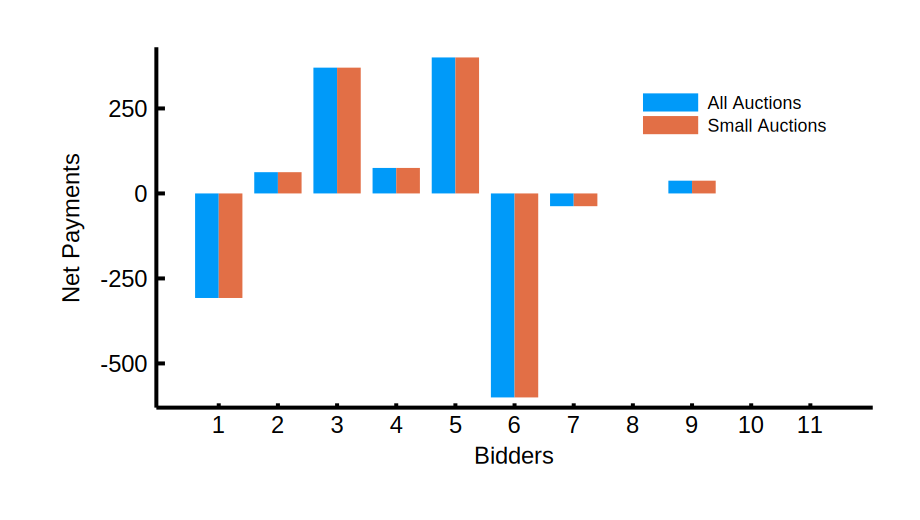

In [178]:
fig = groupedbar(names, payments, group = auct_type, ylabel = "Net Payments", title = "",
        legendfont=font(3), xtickfont=font(4), ytickfont=font(4), guidefont=font(4), line=0,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false,
        legend=:topright, xlabel = "Bidders")
plot!(size=(230,130))
savefig("fig_5.png")
fig

<br><br><br><br>

# 3. Structural Analysis

## Step 1

### Normalize the bids

## Step 3

### Estimate $\bar{H}_r$

### Estimate $G_m$

### Estimate $H_r$

## Step 4

### Estimate bid function for each bidder

### Estimate $\alpha_k$ (participation probabilities)

### Construct $G_{-i}$

### Construct $g_{-i}$

### Construct $v_{ik}$

### Figure 2